Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva

## Uvod u znanost o podacima 2021/2022
https://www.fer.unizg.hr/predmet/uuzop

------------------------------

### Early Predictor for Student Success Based on Behavioural and Demographical Indicators

*Verzija: 1.0
<br>
Zadnji put ažurirano: 14.11.2021.*

------------------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### 1. Studenti po kategorijama

<AxesSubplot:>

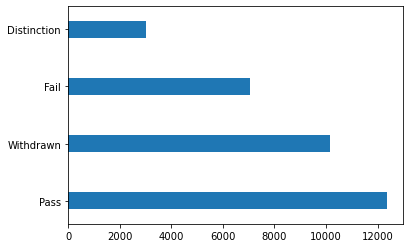

In [8]:
student_info = pd.read_csv('studentInfo.csv')
student_info.final_result.value_counts().plot.barh(width=0.3)

#### 2. Informacije o MOOC-evima

**Napomena:** 'BBB' i 'DDD' imaju različite vrijednosti za *'1st assignment submission day'* od onih u originalnom znanstvenom radu. 

In [9]:
# Jedinstveni 'course-ovi'
assessments_info = pd.read_csv('assessments.csv')
assessments_info_courses = pd.DataFrame(assessments_info.code_module.unique().tolist(), columns=['code_module'])

# '1st assignment submission day'
assessments_info_1st = assessments_info.groupby('code_module', as_index=False).min('date').reindex(columns=['code_module','date', 'id_assessment'])
assessments_info_1st['date'] = 'Day ' + assessments_info_1st['date'].astype(int).astype(str)

# Id-evi prvih assignmenta
first_assignment_ids = assessments_info_1st['id_assessment'].tolist()
del assessments_info_1st['id_assessment']

# 'Number of registered students'
student_info_registered = student_info.groupby('code_module').size().reset_index(name='# of registered students')

# 'Year(run)'
courses_info = pd.read_csv('courses.csv')
courses_info_unique = courses_info.code_module.unique().tolist()

year_run = dict()

for module in courses_info_unique:
    for module_2, year in zip(courses_info.code_module, courses_info.code_presentation):
        if ((module in year_run) and (module == module_2)):
            year_run[module].append(year)
        elif(module == module_2):
            year_run[module] = [year] 

for key in year_run:
    for i in range(len(year_run[key])):
        year_run[key][i] = int(year_run[key][i][:-1])
    year_run[key] = set(year_run[key])
    year_run[key] = ' & '.join(str(e) for e in year_run[key])

courses_info_year_run = pd.DataFrame.from_dict(year_run, orient="index").reset_index(level=0)
courses_info_year_run.columns = ['code_module', 'Year(run)']

# Final MOOC table
temp1 = pd.merge(assessments_info_courses, assessments_info_1st, how="inner")
temp2 = pd.merge(temp1, student_info_registered, how="inner")
final_MOOC = pd.merge(temp2, courses_info_year_run, how="inner")
final_MOOC.columns = ['Course', '1st assignment submission day', '# of registered students', 'Year(run)']

final_MOOC

,Course,1st assignment submission day,# of registered students,Year(run)
0,AAA,Day 19,748,2013 & 2014
1,BBB,Day 12,7909,2013 & 2014
2,CCC,Day 18,4434,2014
3,DDD,Day 20,6272,2013 & 2014
4,EEE,Day 33,2934,2013 & 2014
5,FFF,Day 19,7762,2013 & 2014
6,GGG,Day 61,2534,2013 & 2014


#### 3. Tablica za analizu

U originalnom su radu istraživači varijable *'Educational Level'* i *'Age'* pretvorili u dihotomne varijable, a nije objašnjeno točno kako su to napravili. Problem nastaje jer *'Educational Level'* ima 5 različitih stupnjeva, dok *'Age'* ima 3 različita stupnja. <br>**Iz tog razloga će *'Educational Level'* biti podijeljen na sljedeći način:**
<br>
<br>
*'Lower education'* => *'No Formal quals'* + *'Lower Than A Level'*
<br>
*'Higher education'* => *'A Level or Equivalent'* + *'HE Qualification'* + *'Post Graduate Qualification'*
<br>
<br>
**Dok će *'Age'* biti podijeljen na sljedeći način:**
<br>
<br>
*'Under 35'* => *'0-35'*
<br>
*'Over 35'* => *'35-55'* + *'55<='*

In [23]:
# Vec ucitane tablice: 'studentInfo', 'assessments' i 'courses'
# Treba ucitati: 'studentAssessment', 'studentVle' i 'studentRegistration'
studentVle_info = pd.read_csv('studentVle.csv')
studentAssessment_info = pd.read_csv('studentAssessment.csv')
studentRegistration_info = pd.read_csv('studentRegistration.csv')

# 'Educational Level', 'Age', 'Disability', 'Gender' i 'Previous Attempts' <- sve iz 'studentInfo'

# Podjela 'Education Level-a' u dihotomnu varijablu
student_info.loc[(student_info['highest_education'] == 'No Formal quals') | (student_info['highest_education'] == 'Lower Than A Level'), 'highest_education'] = 'Lower education' 
student_info.loc[(student_info['highest_education'] == 'A Level or Equivalent') | (student_info['highest_education'] == 'HE Qualification') | (student_info['highest_education'] == 'Post Graduate Qualification') , 'highest_education'] = 'Higher education' 

# Podjela 'Age-a' u dihotomnu varijablu
student_info.loc[(student_info['age_band'] == '0-35'), 'age_band'] = 'Under 35' 
student_info.loc[(student_info['age_band'] == '35-55') | (student_info['age_band'] == '55<='), 'age_band'] = 'Over 35' 

# Sve potrebne varijable iz 'studentInfo'
var_from_studentInfo = student_info[['id_student', 'highest_education', 'age_band', 'disability', 'gender', 'num_of_prev_attempts']]
var_from_studentInfo.columns = ['id_student', 'Educational Level', 'Age', 'Disability', 'Gender', 'Previous Attempts']


# 'First Assignment Mark' <- 'studentAssessment'
var_from_studentAssessment = studentAssessment_info.loc[studentAssessment_info['id_assessment'].isin(first_assignment_ids), ['id_student', 'score']]
var_from_studentAssessment.columns = ['id_student', 'First Assignment Mark']


# 'Clicks till Course Starts' <- 'studentVle'
var_from_studentVle = studentVle_info.groupby('id_student', as_index=False).sum('sum_click')
var_from_studentVle = var_from_studentVle[['id_student', 'sum_click']]
var_from_studentVle.columns = ['id_student', 'Clicks till Course Starts']


# 'Registration Date' <- 'studentRegistration'
var_from_studentRegistration = studentRegistration_info[['id_student', 'date_registration']]
var_from_studentRegistration.columns = ['id_student', 'Registration Date']

# Spajanje u jednu tablicu
temp1 = pd.merge(var_from_studentInfo, var_from_studentAssessment, how="inner")
temp2 = pd.merge(temp1, var_from_studentVle, how="inner")
analysis_table = pd.merge(temp2, var_from_studentRegistration, how="inner")
analysis_table.columns = ['id_student', 'Educational Level', 'Age', 'Disability', 'Gender', 'Previous Attempts', 'First Assignment Mark', 'Clicks till Course Starts', 'Registration Date']
analysis_table = analysis_table.dropna()
analysis_table['First Assignment Mark'] = analysis_table['First Assignment Mark'].astype(int)
analysis_table['Clicks till Course Starts'] = analysis_table['Clicks till Course Starts'].astype(int)
analysis_table['Registration Date']= analysis_table['Registration Date'].astype(int)


analysis_table.head()

,id_student,Educational Level,Age,Disability,Gender,Previous Attempts,First Assignment Mark,Clicks till Course Starts,Registration Date
0,11391,Higher education,Over 35,N,M,0,78,934,-159
1,28400,Higher education,Over 35,N,F,0,70,1435,-53
2,31604,Higher education,Over 35,N,F,0,72,2158,-52
3,32885,Lower education,Under 35,N,F,0,69,1034,-176
4,38053,Higher education,Over 35,N,M,0,79,2445,-110
